In [1]:
from google.colab import userdata
import os
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

!kaggle competitions download -c store-sales-time-series-forecasting

!unzip -o store-sales-time-series-forecasting.zip -d store-sales

store-sales-time-series-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  store-sales-time-series-forecasting.zip
  inflating: store-sales/holidays_events.csv  
  inflating: store-sales/oil.csv     
  inflating: store-sales/sample_submission.csv  
  inflating: store-sales/stores.csv  
  inflating: store-sales/test.csv    
  inflating: store-sales/train.csv   
  inflating: store-sales/transactions.csv  


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DATA_PATH = 'store-sales/'
data_files = [f for f in os.listdir(DATA_PATH) if f.endswith('.csv')]

df = {}
for filename in data_files:
  df_name = filename.split('.')[0]
  df[df_name] = pd.read_csv(os.path.join(DATA_PATH, filename))
  print(f'{filename} loaded')

stores.csv loaded
train.csv loaded
holidays_events.csv loaded
oil.csv loaded
transactions.csv loaded
sample_submission.csv loaded
test.csv loaded


In [4]:
pd.options.display.float_format = '{:.4f}'.format

# EDA


## Preview

In [5]:
train_data = df['train'].copy()

In [6]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0000,0
1,1,2013-01-01,1,BABY CARE,0.0000,0
2,2,2013-01-01,1,BEAUTY,0.0000,0
3,3,2013-01-01,1,BEVERAGES,0.0000,0
4,4,2013-01-01,1,BOOKS,0.0000,0


In [7]:
train_data.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.1330,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.5530,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.7290,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.0000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.0000,0


In [8]:
train_data.shape

(3000888, 6)

In [9]:
print(train_data.info())
train_data.dtypes.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None


,count
int64,3
object,2
float64,1


In [10]:
print(train_data.isnull().sum())
print(train_data.duplicated().sum())

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
0


In [11]:
train_data[['id', 'store_nbr']] = train_data[['id', 'store_nbr']].astype('category')
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.describe(include='all')

,id,date,store_nbr,family,sales,onpromotion
count,3000888.0000,3000888,3000888.0000,3000888,3000888.0000,3000888.0000
unique,3000888.0000,NaN,54.0000,33,NaN,NaN
top,3000887.0000,NaN,1.0000,AUTOMOTIVE,NaN,NaN
freq,1.0000,NaN,55572.0000,90936,NaN,NaN
mean,NaN,2015-04-24 08:27:04.703088384,NaN,NaN,357.7757,2.6028
min,NaN,2013-01-01 00:00:00,NaN,NaN,0.0000,0.0000
25%,NaN,2014-02-26 18:00:00,NaN,NaN,0.0000,0.0000
50%,NaN,2015-04-24 12:00:00,NaN,NaN,11.0000,0.0000
75%,NaN,2016-06-19 06:00:00,NaN,NaN,195.8473,0.0000
max,NaN,2017-08-15 00:00:00,NaN,NaN,124717.0000,741.0000


In [12]:
[col for col in train_data.columns if train_data[col].nunique() == 1]

[]

For now skip data and id features

In [13]:
train_data.drop(columns=['id', 'date'], inplace=True)

Sales can be expressed discretely or continuously, depending on the family of product. It is clear that there are two tasks in one - predicting a discrete random variable for one subset of products and predicting a continuous one for the other.

In [51]:
discrete_sales_families = []
continuous_sales_families = []
for family, group in train_data.groupby('family'):
  if np.allclose(group['sales'], group['sales'].astype('int')):
    discrete_sales_families.append(family)
  else:
    continuous_sales_families.append(family)

print(discrete_sales_families)
print(continuous_sales_families)

['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'CELEBRATION', 'CLEANING', 'DAIRY', 'EGGS', 'GROCERY II', 'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER', 'MAGAZINES', 'PERSONAL CARE', 'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'SCHOOL AND OFFICE SUPPLIES']
['BREAD/BAKERY', 'DELI', 'FROZEN FOODS', 'GROCERY I', 'MEATS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SEAFOOD']


Divide it on 2 datasets

In [52]:
discrete_sales = train_data[train_data['family'].isin(discrete_sales_families)]
continuous_sales = train_data[train_data['family'].isin(continuous_sales_families)]

## Discrete sales

In [53]:
print(discrete_sales.shape)
discrete_sales.describe(include='all')

(2182464, 4)


,store_nbr,family,sales,onpromotion
count,2182464.0000,2182464,2182464.0000,2182464.0000
unique,54.0000,24,NaN,NaN
top,1.0000,AUTOMOTIVE,NaN,NaN
freq,40416.0000,90936,NaN,NaN
mean,NaN,NaN,207.7384,1.4345
std,NaN,NaN,733.4666,6.8020
min,NaN,NaN,0.0000,0.0000
25%,NaN,NaN,0.0000,0.0000
50%,NaN,NaN,3.0000,0.0000
75%,NaN,NaN,47.0000,0.0000


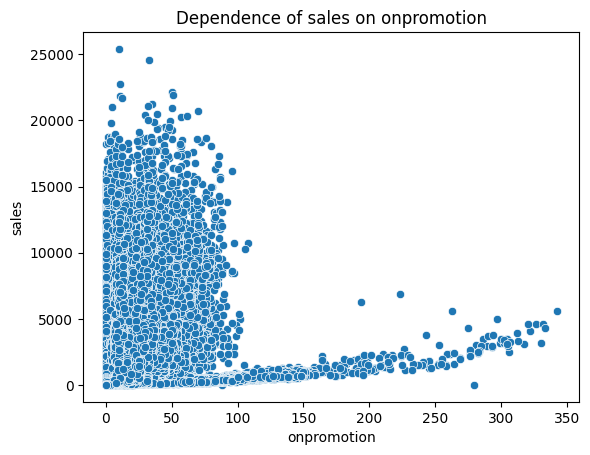

In [34]:
sns.scatterplot(data=discrete_sales, x='onpromotion', y='sales')
plt.title('Dependence of sales on onpromotion')
plt.xlabel('onpromotion')
plt.ylabel('sales')
plt.show()

It tells nothing, we should analyse dependence for each family of products

In [35]:
len(discrete_sales_families)

24

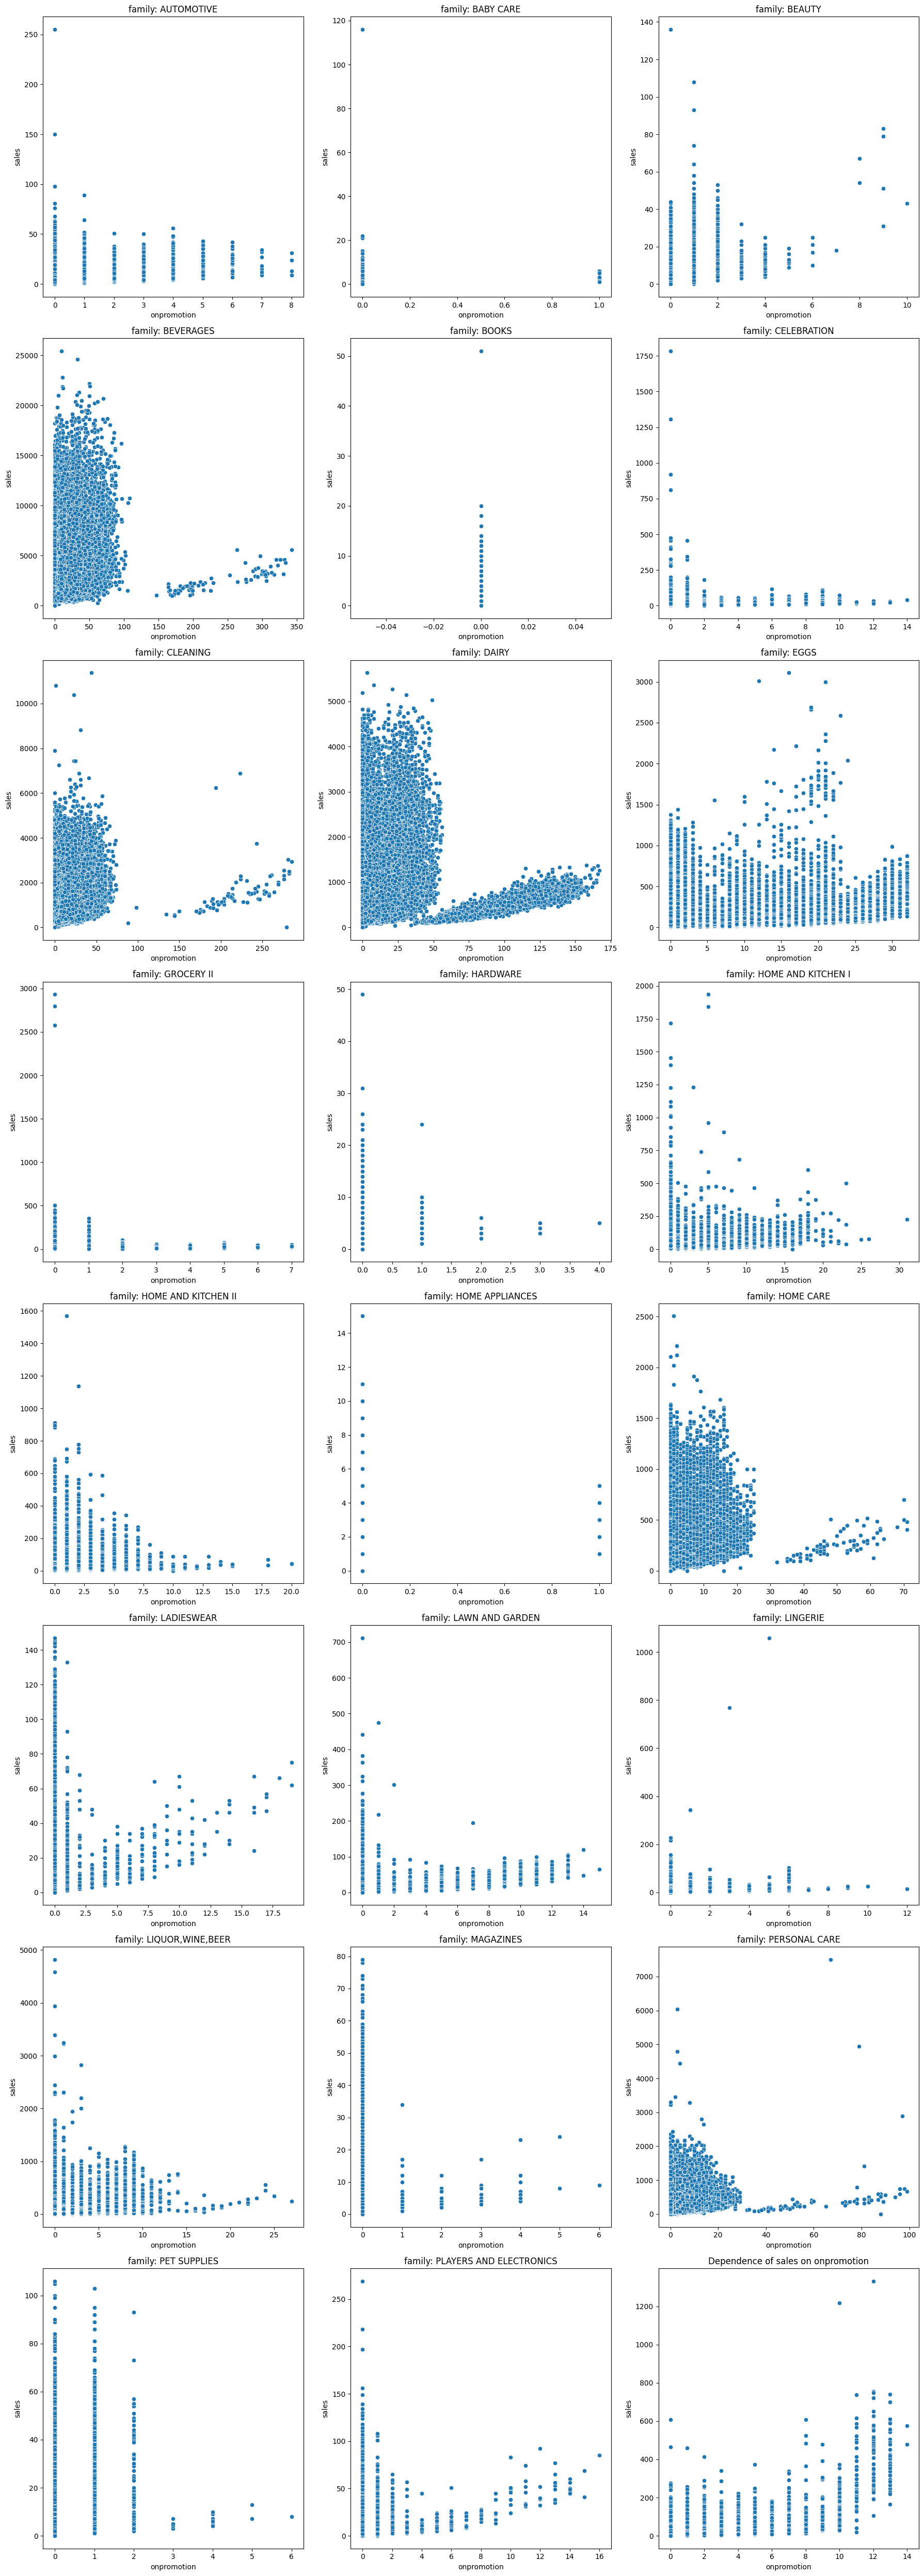

In [36]:
fig, axes = plt.subplots(8, 3, figsize=(18, 50))
axes = axes.flatten()
for i, ax in enumerate(axes):
  family = discrete_sales_families[i]
  family_df = discrete_sales[discrete_sales['family'] == family]
  sns.scatterplot(data=family_df, x='onpromotion', y='sales', ax=ax)
  ax.set_title(f'family: {family}')

plt.title(f'Dependence of sales on onpromotion')
plt.tight_layout()
plt.show()

The relationship between sales and onpromotion is quite complicated, it clearly needs to take into account the seasonality of sales, trends, etc., while it is clear that onpromotion is insufficient

In [48]:
print(discrete_sales.groupby('family')[['onpromotion', 'sales']].corr().iloc[0::2, -1])

family                                 
AUTOMOTIVE                  onpromotion   0.2098
BABY CARE                   onpromotion   0.0550
BEAUTY                      onpromotion   0.3424
BEVERAGES                   onpromotion   0.3727
BOOKS                       onpromotion      NaN
CELEBRATION                 onpromotion   0.1133
CLEANING                    onpromotion   0.1952
DAIRY                       onpromotion   0.1093
EGGS                        onpromotion   0.1592
GROCERY II                  onpromotion   0.0116
HARDWARE                    onpromotion   0.0302
HOME AND KITCHEN I          onpromotion   0.2759
HOME AND KITCHEN II         onpromotion   0.3623
HOME APPLIANCES             onpromotion   0.0245
HOME CARE                   onpromotion   0.3696
LADIESWEAR                  onpromotion   0.0656
LAWN AND GARDEN             onpromotion   0.2687
LINGERIE                    onpromotion   0.1126
LIQUOR,WINE,BEER            onpromotion   0.2108
MAGAZINES                   o

In addition to SCHOOL AND OFFICE SUPPLIES, onpromotion is not correlated with sales, in general, there is nothing to catch with it yet.

/tmp/ipython-input-2264545441.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  discrete_sales_by_store = discrete_sales.groupby('store_nbr')['sales'].sum().reset_index()


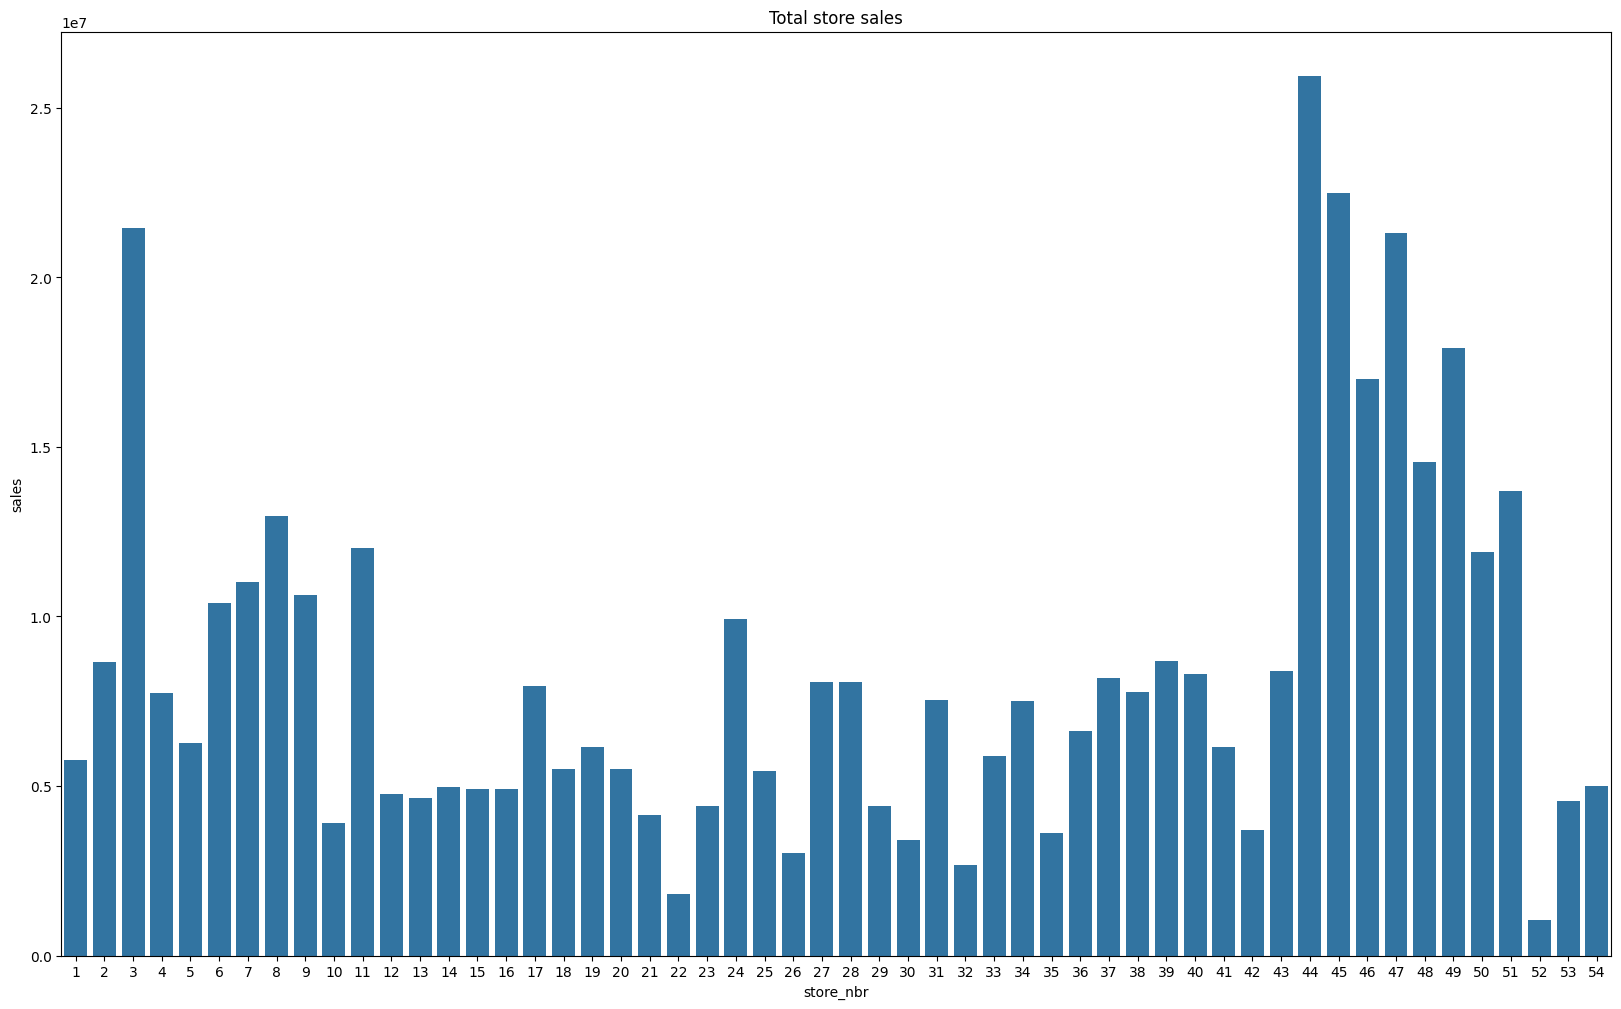

In [54]:
discrete_sales_by_store = discrete_sales.groupby('store_nbr')['sales'].sum().reset_index()
plt.figure(figsize=(20, 12))
sns.barplot(x='store_nbr', y='sales', data=discrete_sales_by_store)
plt.title('Total store sales')
plt.show()

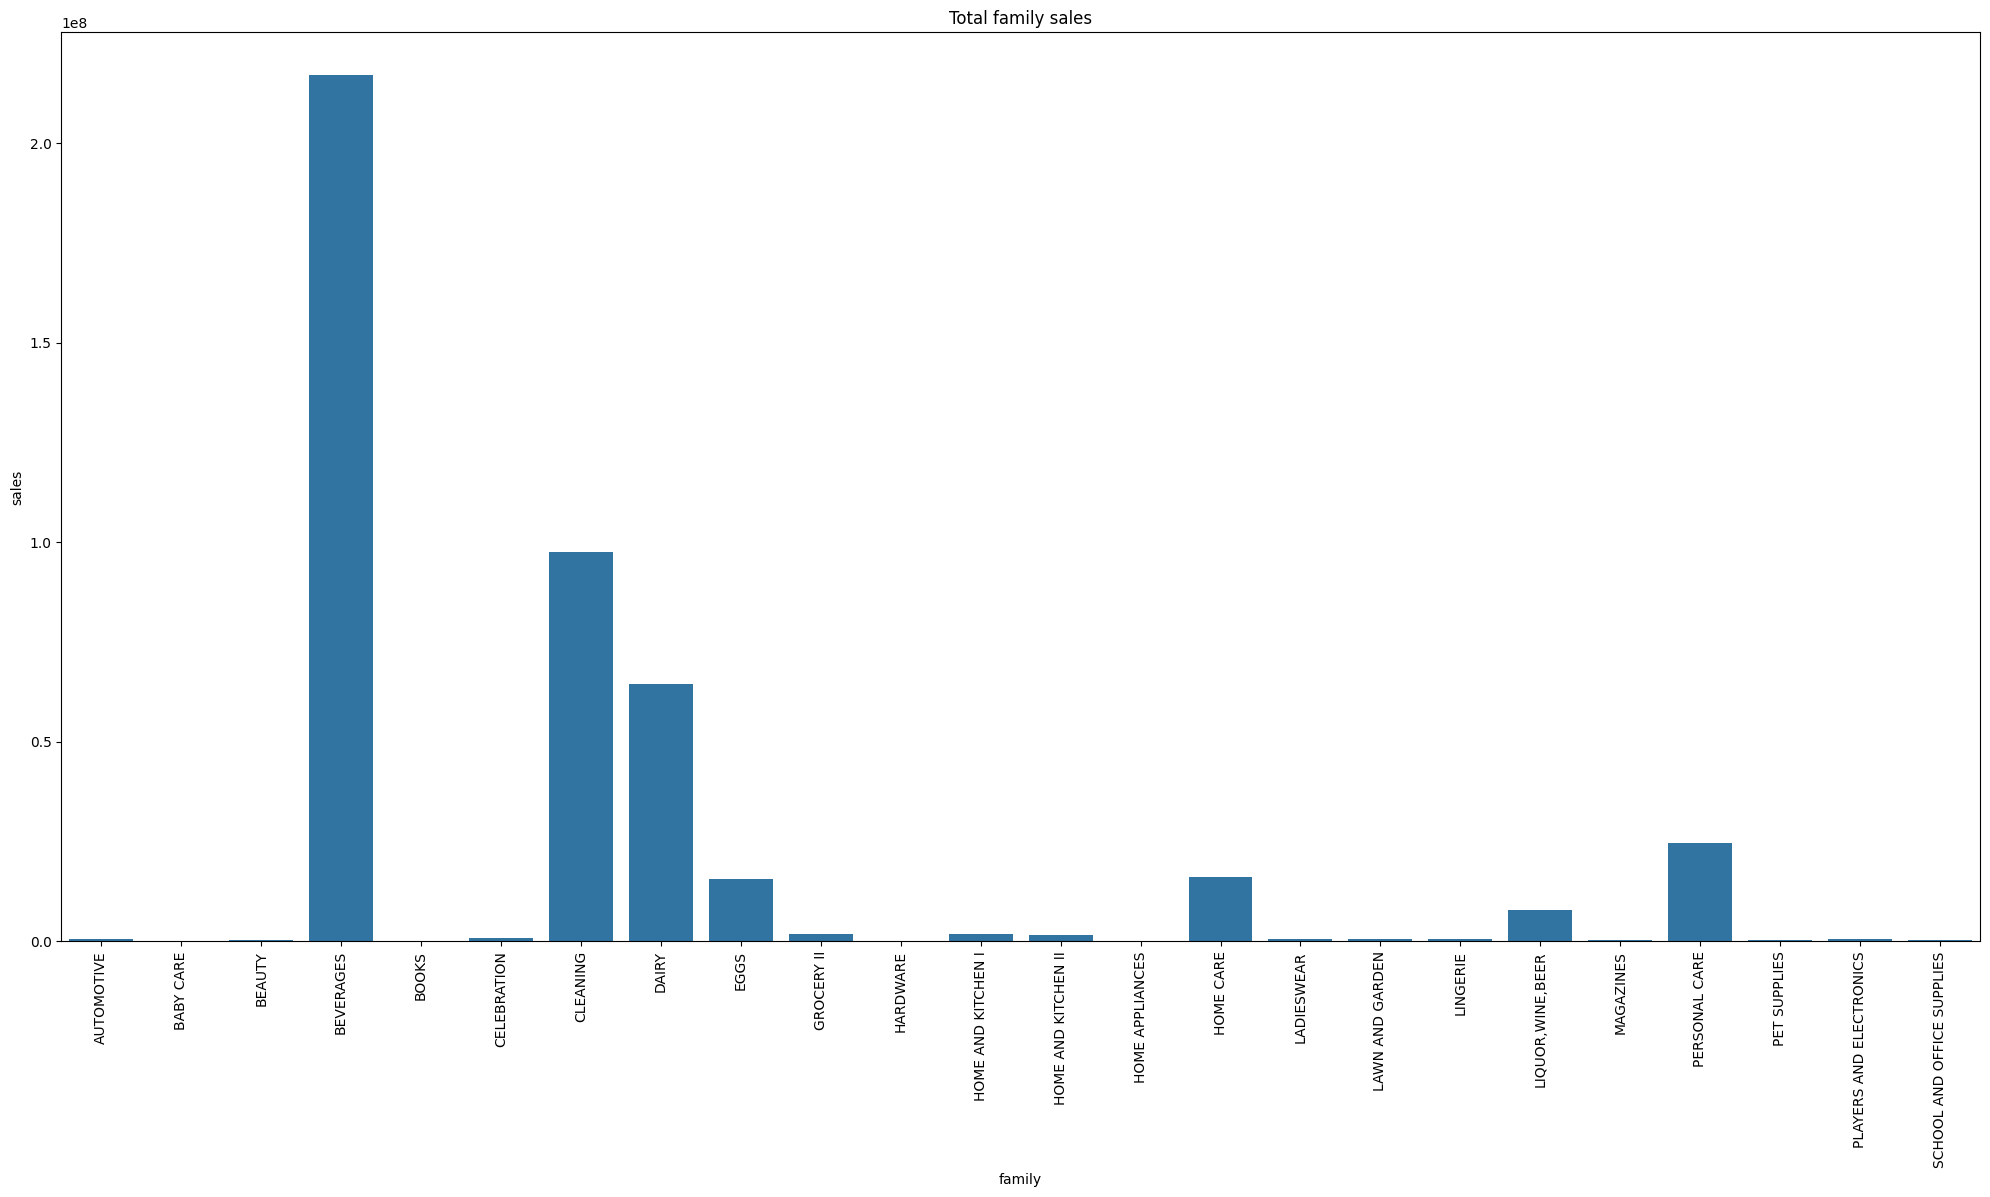

In [58]:
discrete_sales_by_family = discrete_sales.groupby('family')['sales'].sum().reset_index()
plt.figure(figsize=(20, 12))
sns.barplot(x='family', y='sales', data=discrete_sales_by_family)
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Total family sales')
plt.show()

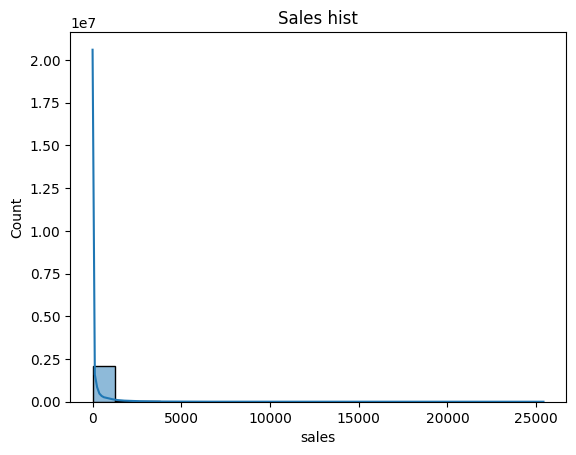

In [61]:
sns.histplot(discrete_sales['sales'], bins=20, kde=True)
plt.title('Sales hist')
plt.show()

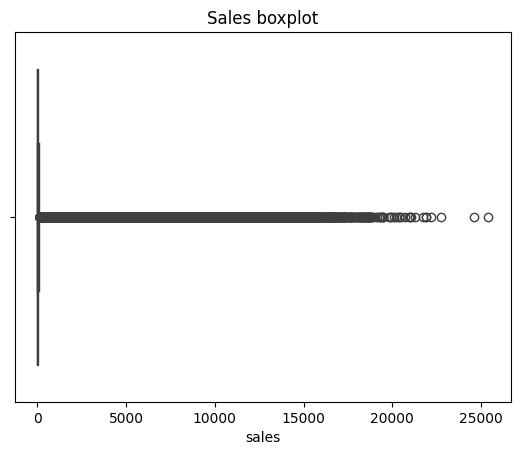

In [63]:
sns.boxplot(x=discrete_sales['sales'])
plt.title('Sales boxplot')
plt.show()

In [77]:
print((discrete_sales['sales'] == 0).sum() / len(discrete_sales))

0.3868856485147063


## Continuous sales

In [67]:
print(continuous_sales.shape)
continuous_sales.describe(include='all')

(818424, 4)


,store_nbr,family,sales,onpromotion
count,818424.0000,818424,818424.0000,818424.0000
unique,54.0000,9,NaN,NaN
top,1.0000,BREAD/BAKERY,NaN,NaN
freq,15156.0000,90936,NaN,NaN
mean,NaN,NaN,757.8753,5.7183
std,NaN,NaN,1672.7504,20.2660
min,NaN,NaN,0.0000,0.0000
25%,NaN,NaN,38.9937,0.0000
50%,NaN,NaN,171.0000,0.0000
75%,NaN,NaN,548.0000,1.0000


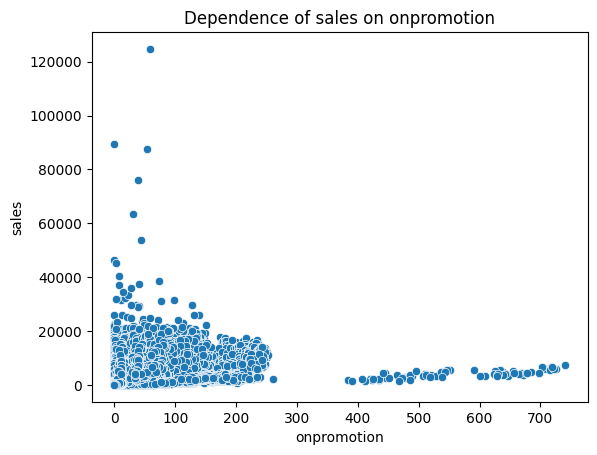

In [68]:
sns.scatterplot(data=continuous_sales, x='onpromotion', y='sales')
plt.title('Dependence of sales on onpromotion')
plt.xlabel('onpromotion')
plt.ylabel('sales')
plt.show()

In [69]:
len(continuous_sales_families)

9

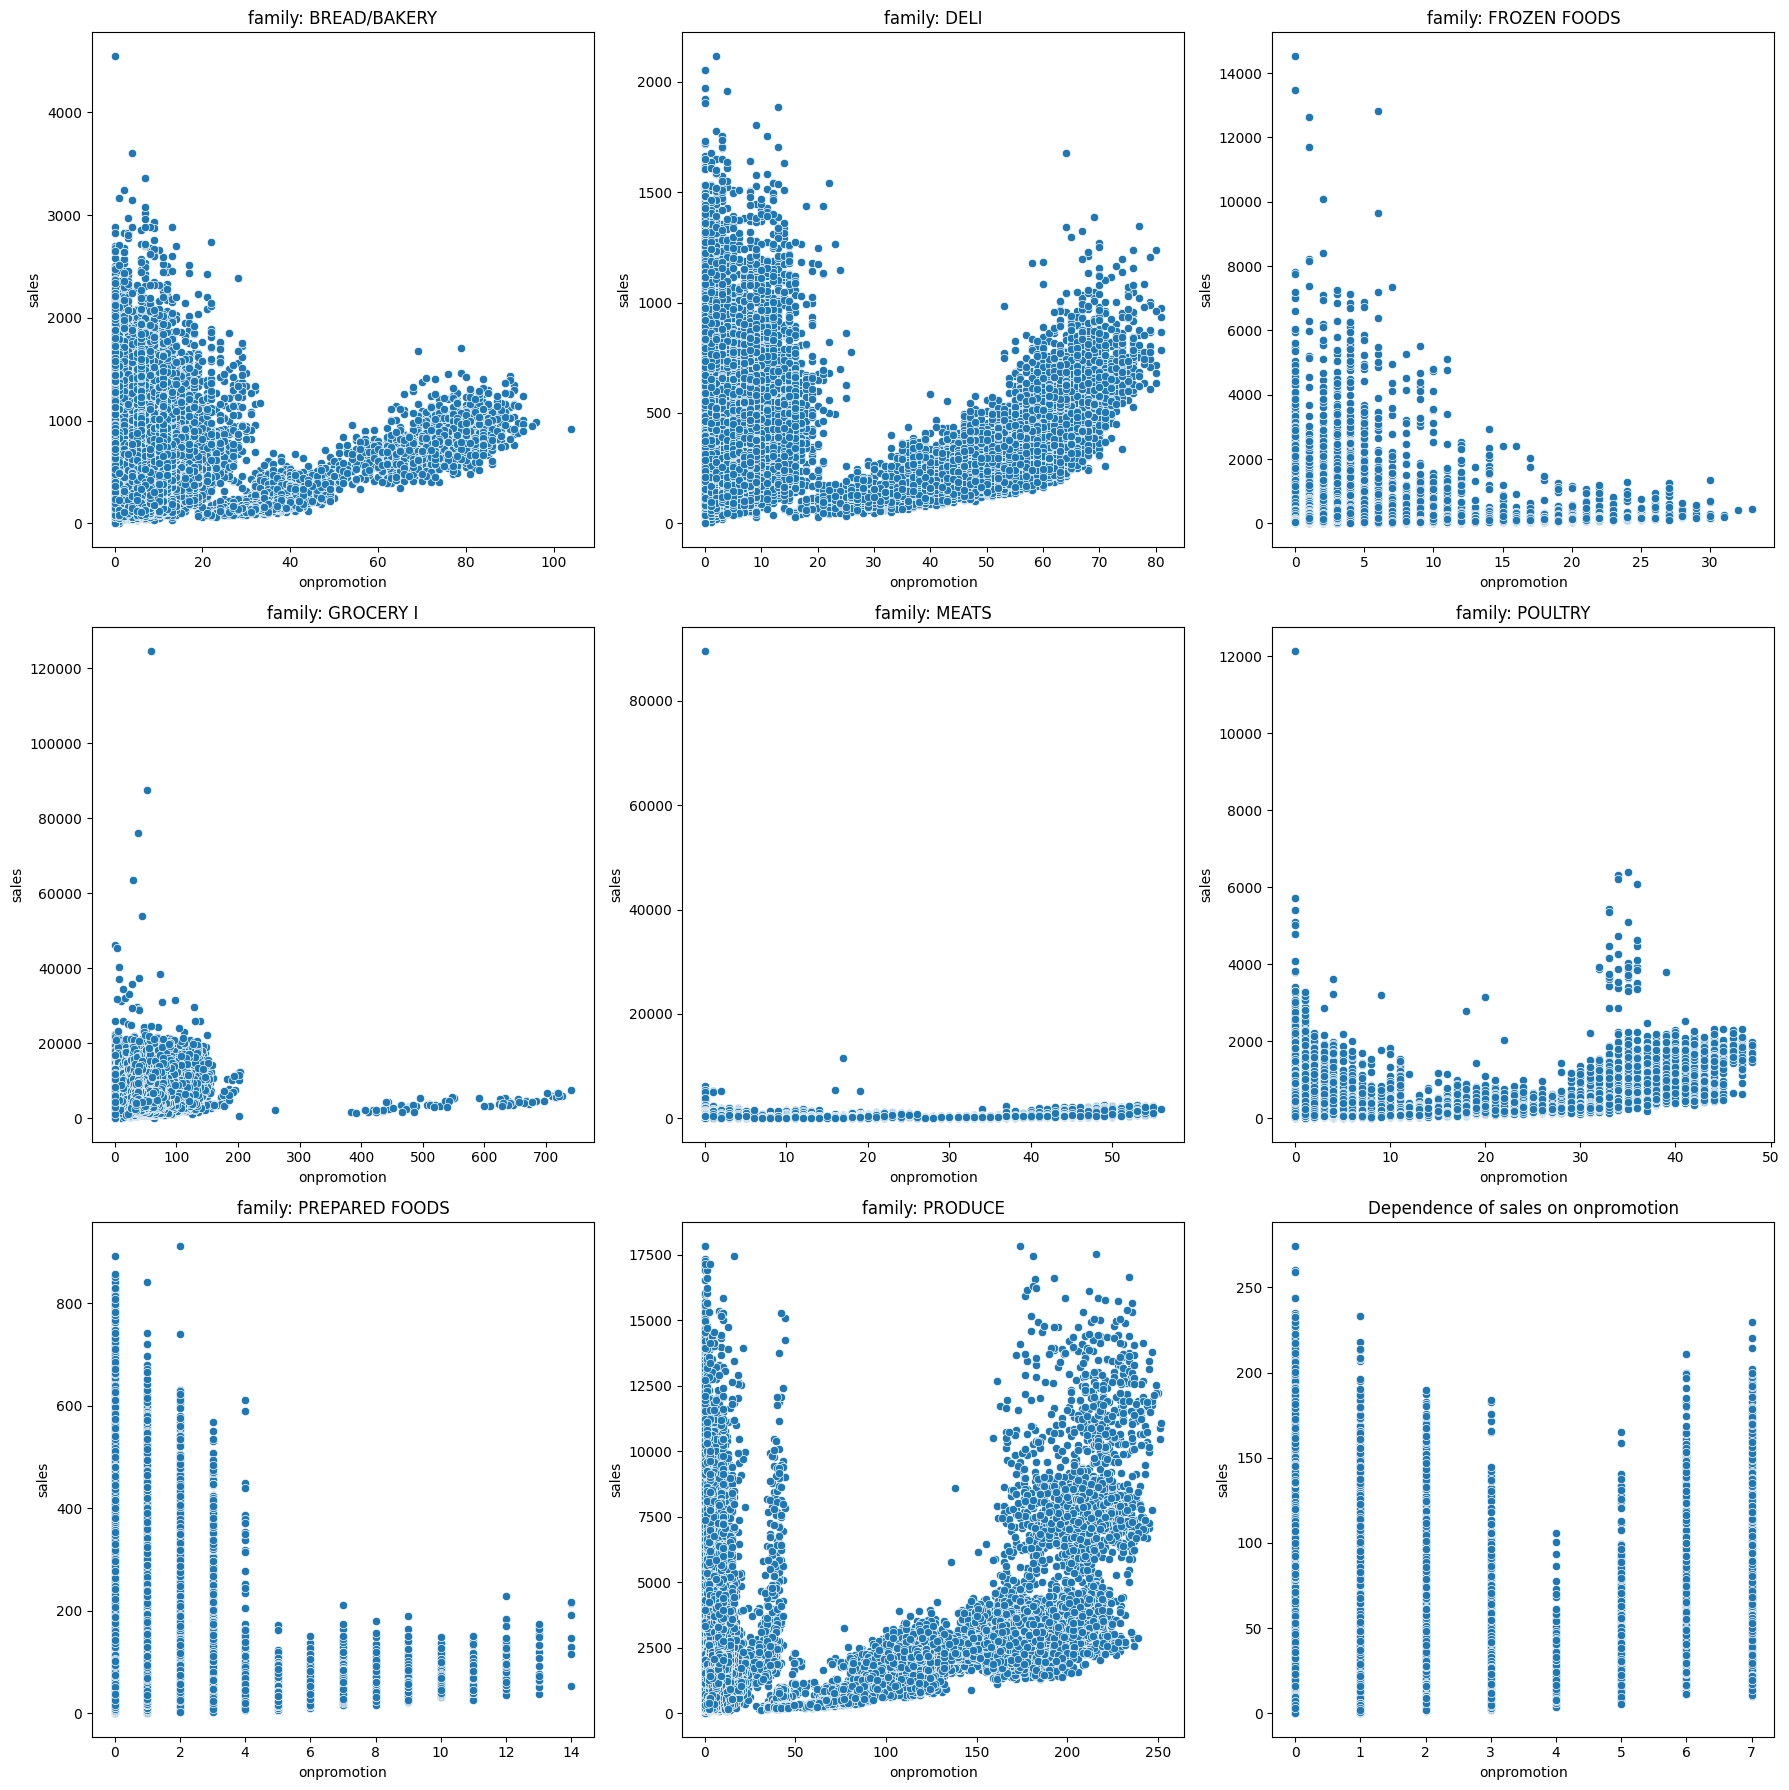

In [70]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()
for i, ax in enumerate(axes):
  family = continuous_sales_families[i]
  family_df = continuous_sales[continuous_sales['family'] == family]
  sns.scatterplot(data=family_df, x='onpromotion', y='sales', ax=ax)
  ax.set_title(f'family: {family}')

plt.title(f'Dependence of sales on onpromotion')
plt.tight_layout()
plt.show()

In [71]:
print(continuous_sales.groupby('family')[['onpromotion', 'sales']].corr().iloc[0::2, -1])

family                     
BREAD/BAKERY    onpromotion    0.1330
DELI            onpromotion    0.1559
FROZEN FOODS    onpromotion    0.1194
GROCERY I       onpromotion    0.2777
MEATS           onpromotion    0.2256
POULTRY         onpromotion    0.2448
PREPARED FOODS  onpromotion   -0.0034
PRODUCE         onpromotion    0.3569
SEAFOOD         onpromotion    0.2894
Name: sales, dtype: float64


/tmp/ipython-input-513591959.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  continuous_sales_by_store = continuous_sales.groupby('store_nbr')['sales'].sum().reset_index()


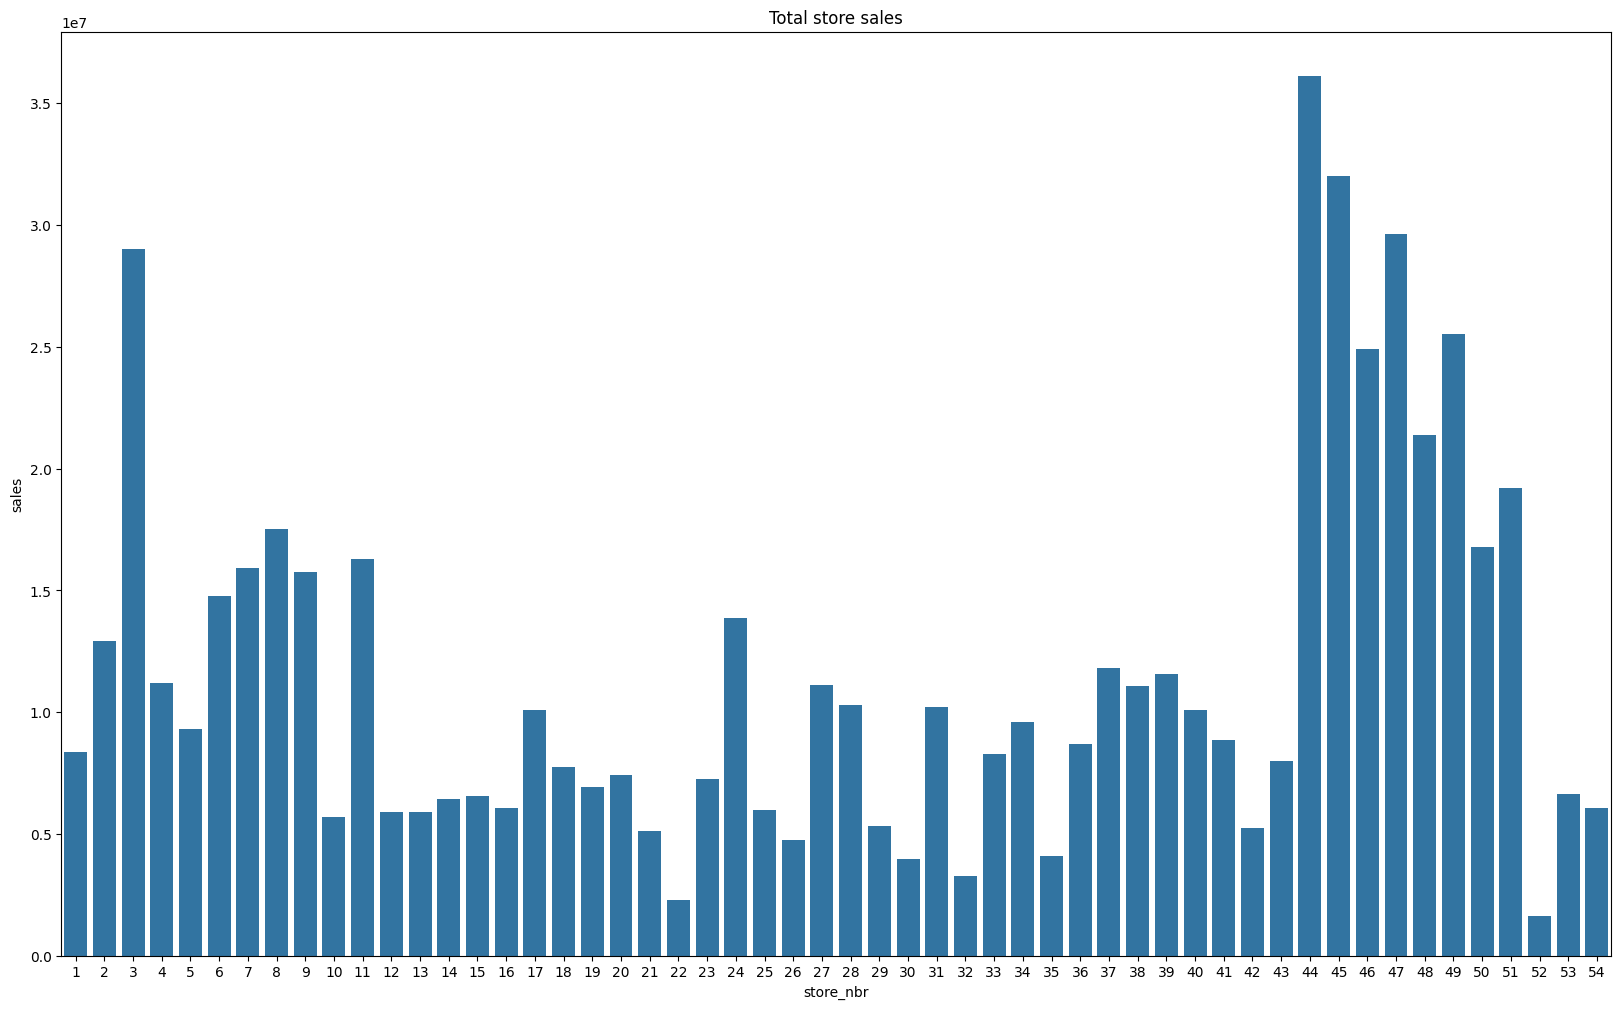

In [72]:
continuous_sales_by_store = continuous_sales.groupby('store_nbr')['sales'].sum().reset_index()
plt.figure(figsize=(20, 12))
sns.barplot(x='store_nbr', y='sales', data=continuous_sales_by_store)
plt.title('Total store sales')
plt.show()

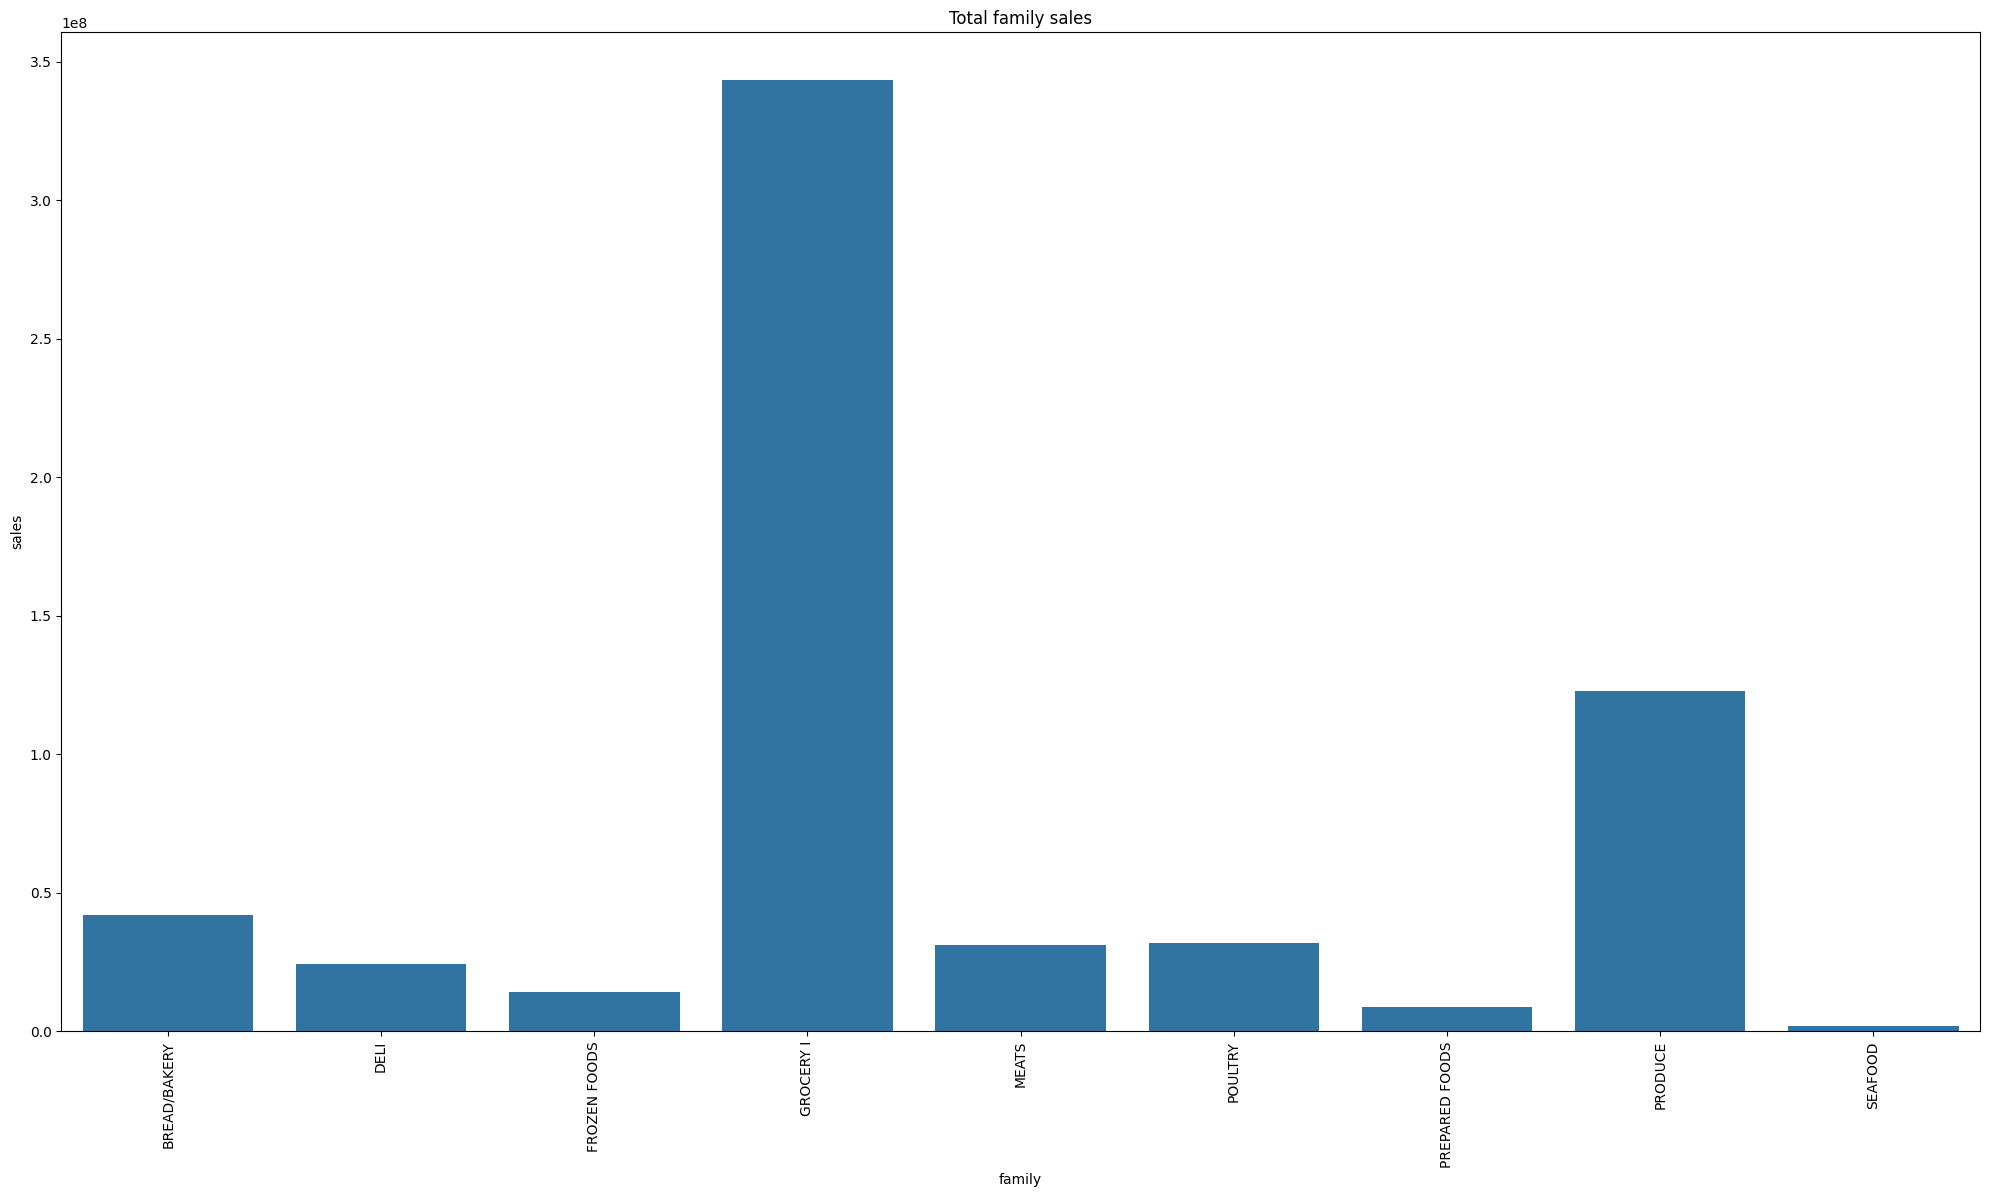

In [73]:
continuous_sales_by_family = continuous_sales.groupby('family')['sales'].sum().reset_index()
plt.figure(figsize=(20, 12))
sns.barplot(x='family', y='sales', data=continuous_sales_by_family)
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Total family sales')
plt.show()

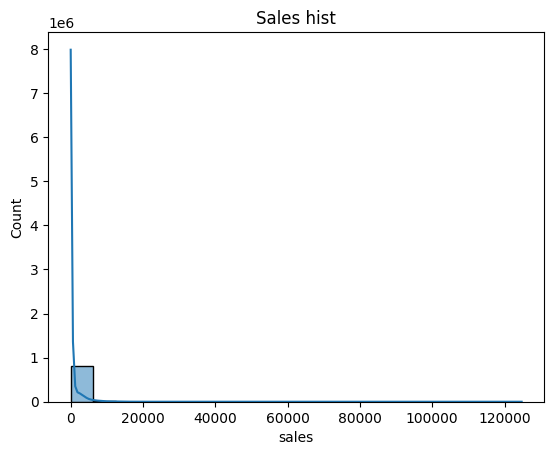

In [74]:
sns.histplot(continuous_sales['sales'], bins=20, kde=True)
plt.title('Sales hist')
plt.show()

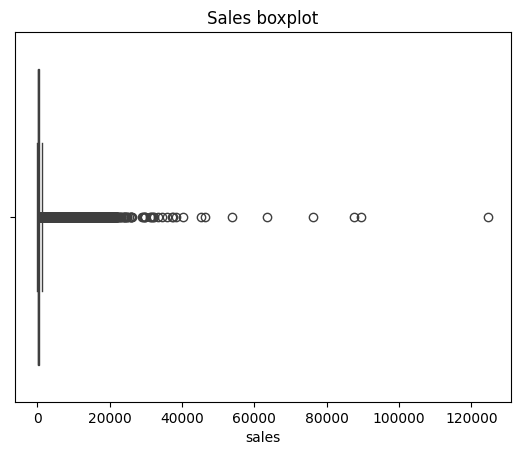

In [75]:
sns.boxplot(x=continuous_sales['sales'])
plt.title('Sales boxplot')
plt.show()

In [79]:
print((continuous_sales['sales'] == 0).sum() / len(continuous_sales))

0.1157908370233522


## Common statistics

/tmp/ipython-input-1086751269.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_by_store = train_data.groupby('store_nbr')['sales'].sum().reset_index()


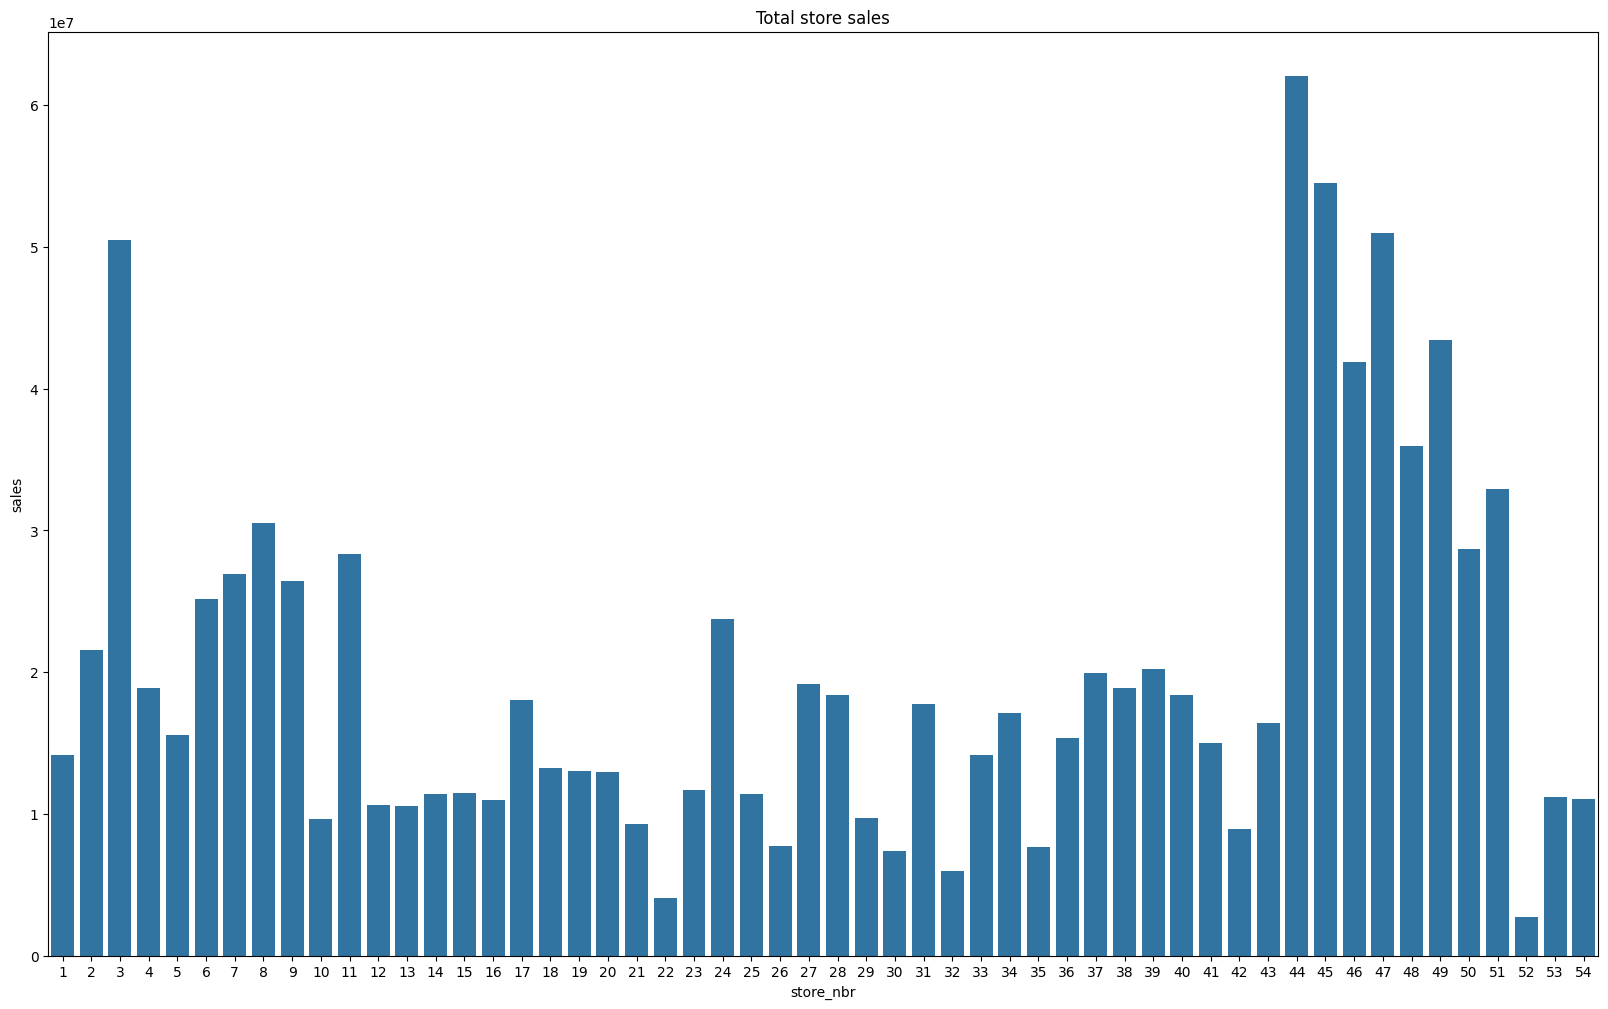

In [80]:
sales_by_store = train_data.groupby('store_nbr')['sales'].sum().reset_index()
plt.figure(figsize=(20, 12))
sns.barplot(x='store_nbr', y='sales', data=sales_by_store)
plt.title('Total store sales')
plt.show()

In [81]:
(train_data['sales'] == 0).sum() / len(train_data)

np.float64(0.3129506999261552)

# Notes
1. The data in train is arranged in ascending order by date and by store_nbr
2. The data has no missing values
3. The data was collected from January 1, 2013 to August 15, 2017
4. There are 54 stores in total, 33 family of products
5. Since the target can be either discrete or continuous, depending on the family of product, it is necessary to create two different models and a shell above them, which distributes them into models at the input of the test data, respectively (depending on the family of product obtained)
6. The relationship between sales and onpromotion is quite complicated, it clearly needs to take into account the seasonality of sales, trends, etc., while it is clear that onpromotion is insufficient
7. There are rare-selling family of products, and there are families of products that are constantly on sale. In general, this is logical, but more than that, it suggests that before predicting "how much they will buy," one can predict "whether they will buy at all." Moreover, this can be done by a single binary classifier, that is, it does not need to divide the tasks into two - a discrete target and a continuous one, because it will simply predict 0 or 1. Of course, it becomes even more clear that seasonality greatly affects the saleability of goods.
8.The previous point is confirmed by the fact that the number of zeros among sales is already 31%
9.Stores are divided into small, medium and large by the number of sales (can be binized)


# Summary
I'm thinking of taking a two-step approach to the task:
1. Train a classifier (I'll try CatBoost, NB, Random Forest, and others, maybe) to predict whether there will be a sale in principle or not. It is clear that CatBoost immediately becomes attractive for this, because one of the most important features is the product family. Some are sold on an ongoing basis, but I'll try a variety of approaches. I will also take into account the class imbalance, and that it is worth penalizing more for an erroneous prediction of zero (that there will be no sale).
2. Train two regressors, one for discrete and the other for continuous targeting. Or is it not..? Or choose some suitable distribution, say, Poisson for GLM, or for the same CatBoost (but different) ... hmm.. the time will come for experiments and we will find out.


The next notebook is EDA — Iteration 2: Time Series Focus.